# NNCLR example

## Imports

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
# import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers

from data_loader import load_e4_dataset
from augmentations import *
from encoder import encoder
from nnclr import NNCLR 

%matplotlib inline

## Set configuration parameters

In [2]:
### Hyperparameters
try:
    AUTOTUNE = tf.data.AUTOTUNE     
except:
    AUTOTUNE = tf.data.experimental.AUTOTUNE

temperature = 0.1        # the temperature for the softmax function in the contrastive loss
queue_size = 1000        # the size of the queue for storing the feature vectors

width = 64                  # the size of the output embedding vector for each sequence
pretrain_num_epochs = 100   # the number of epochs to pretrain the model
finetune_num_epochs = 100    # The number of epochs to fine-tune the model.
BATCH_SIZE = 16             # the batch size for training
SHUFFLE_BUFFER_SIZE = 1000  # the buffer size for shuffling the dataset
k_size = 16                 # the size of the kernel for the 1D convolutional layer in the encoder
n_classes = 6               # the number of classes in the dataset

t_names = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']

## Load the data

NNCLR takes in both the unlabeled and labeled data. The self-supervised encoder is trained on both the labeled and unlabeled data. The labeled data is used to train the classifier.

In [3]:
(batch_size, train_dataset, unlabeled_train_dataset, labeled_train_dataset, test_dataset, 
    x_train, y_train, x_validate, y_validate, x_test, y_test) = load_e4_dataset()

Processing  1574621345_A01F11.zip
Unzipping e4 file in local directory c:\Users\vangelis\Files\Academia\Research\DeepLearning\Self-Supervised-Learning\NNCLR_keras\TimeSeriesNNCLR/temp
c:\Users\vangelis\Files\Academia\Research\DeepLearning\Self-Supervised-Learning\NNCLR_keras\TimeSeriesNNCLR/temp/ACC.csv Sample frequency =  32.0  Hz
File start time =  Sun, 24 Nov 2019 12:49:05
File end time   =  Sun, 24 Nov 2019 12:58:11
Tag info (button presses) from tags.csv
    UTC_time          Local Time
0 1574621375.17 Sun, 24 Nov 2019 12:49:35
1 1574621774.22 Sun, 24 Nov 2019 12:56:14
Label Counts
 label
Upstairs      6208
Downstairs    5889
Undefined     5405
Name: count, dtype: int64
No NaN entries found
shapes call broke when making the function - not sure why
Processing  1574622389_A01F11.zip
Unzipping e4 file in local directory c:\Users\vangelis\Files\Academia\Research\DeepLearning\Self-Supervised-Learning\NNCLR_keras\TimeSeriesNNCLR/temp
c:\Users\vangelis\Files\Academia\Research\DeepLearnin

In [4]:
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_validate shape:", x_validate.shape)
print("y_validate shape:", y_validate.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (380, 96, 4)
y_train shape: (380,)
x_validate shape: (329, 96, 4)
y_validate shape: (329,)
x_test shape: (338, 96, 4)
y_test shape: (338,)


## Pre-train NNCLR

### Specify the encoder

In [6]:
input_shape = x_train[0].shape # Get the shape from the first element of the training set

# Create the encoder model
encoder_model = keras.Sequential(
		[
			keras.Input(shape=input_shape),
			layers.Conv1D(filters=100, kernel_size=9, activation='relu'),
			layers.Conv1D(filters=100, kernel_size=9, activation='relu'),
			layers.Dropout(0.5),
			layers.MaxPooling1D(pool_size=2),
			layers.Flatten(),
			layers.Dense(width, activation='relu')
   		],
        name="encoder_model",
    )
encoder_model.summary()

Model: "encoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 88, 100)           3700      
                                                                 
 conv1d_3 (Conv1D)           (None, 80, 100)           90100     
                                                                 
 dropout_1 (Dropout)         (None, 80, 100)           0         
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 40, 100)           0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 4000)              0         
                                                                 
 dense_2 (Dense)             (None, 64)                256064    
                                                     

In [7]:
model = NNCLR(temperature=temperature, queue_size=queue_size, input_shape=input_shape, output_width=width, n_classes= n_classes, encoder=encoder_model)

model.compile(
    contrastive_optimizer=keras.optimizers.Adam(),
    probe_optimizer=keras.optimizers.Adam(),
    run_eagerly=None # True = run eagerly, False = run as graph, None = autodetect
)

model.build(input_shape=(None, input_shape[0], input_shape[1]))
model.summary()

Model: "nnclr"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 contrastive_augmenter (Seq  (None, None, 4)           0         
 uential)                                                        
                                                                 
 classification_augmenter (  (None, None, 4)           0         
 Sequential)                                                     
                                                                 
 encoder_model (Sequential)  (None, 64)                349864    
                                                                 
 projection_head (Sequentia  (None, 64)                8320      
 l)                                                              
                                                                 
 linear_probe (Sequential)   (None, 6)                 390       
                                                             

In [8]:
pretrain_history = model.fit(
    train_dataset, epochs=pretrain_num_epochs, validation_data=test_dataset, 
    verbose=2 # 0 = silent, 1 = progress bar, 2 = one line per epoch, 3 = one line per batch
              # Due to a weird bug, the fit function crashes if verbose is set to 1.
)

Epoch 1/100


21/21 - 5s - c_loss: 3.2121 - c_acc: 0.0526 - r_acc: 0.0387 - p_loss: 1.9254 - p_acc: 0.1489 - val_p_loss: 1.9231 - val_p_acc: 0.1538 - 5s/epoch - 220ms/step
Epoch 2/100
21/21 - 1s - c_loss: 3.1487 - c_acc: 0.1053 - r_acc: 0.0774 - p_loss: 1.8178 - p_acc: 0.1550 - val_p_loss: 1.8358 - val_p_acc: 0.1538 - 617ms/epoch - 29ms/step
Epoch 3/100
21/21 - 1s - c_loss: 2.1019 - c_acc: 0.2722 - r_acc: 0.2418 - p_loss: 1.7831 - p_acc: 0.1581 - val_p_loss: 1.8769 - val_p_acc: 0.1509 - 565ms/epoch - 27ms/step
Epoch 4/100
21/21 - 1s - c_loss: 1.7728 - c_acc: 0.3579 - r_acc: 0.3103 - p_loss: 1.7661 - p_acc: 0.1550 - val_p_loss: 1.8627 - val_p_acc: 0.1302 - 554ms/epoch - 26ms/step
Epoch 5/100
21/21 - 1s - c_loss: 1.5781 - c_acc: 0.3782 - r_acc: 0.3140 - p_loss: 1.7765 - p_acc: 0.1246 - val_p_loss: 1.8775 - val_p_acc: 0.1627 - 544ms/epoch - 26ms/step
Epoch 6/100
21/21 - 1s - c_loss: 1.4999 - c_acc: 0.4188 - r_acc: 0.3419 - p_loss: 1.8035 - p_acc: 0.1915 - val_p_loss: 1.8789 - val_p_acc: 0.2101 - 573ms/

### Plot the training loss and accuracy

*Contrastive accuracy*: self-supervised metric, the ratio of cases in which the representation of an image is more similar to its differently augmented version's one, than to the representation of any other image in the current batch.

*Correlation accuracy*: self-supervised metric, the ratio of cases in which the representation of an image is more similar to its differently augmented version's one, than to the representation of any other image in the queue.

*Probe accuracy*: supervised metric, the ratio of cases in which the representation of an image is more similar to its label's one, than to the representation of any other label.

In [9]:
print(pretrain_history.history.keys())

dict_keys(['c_loss', 'c_acc', 'r_acc', 'p_loss', 'p_acc', 'val_p_loss', 'val_p_acc'])


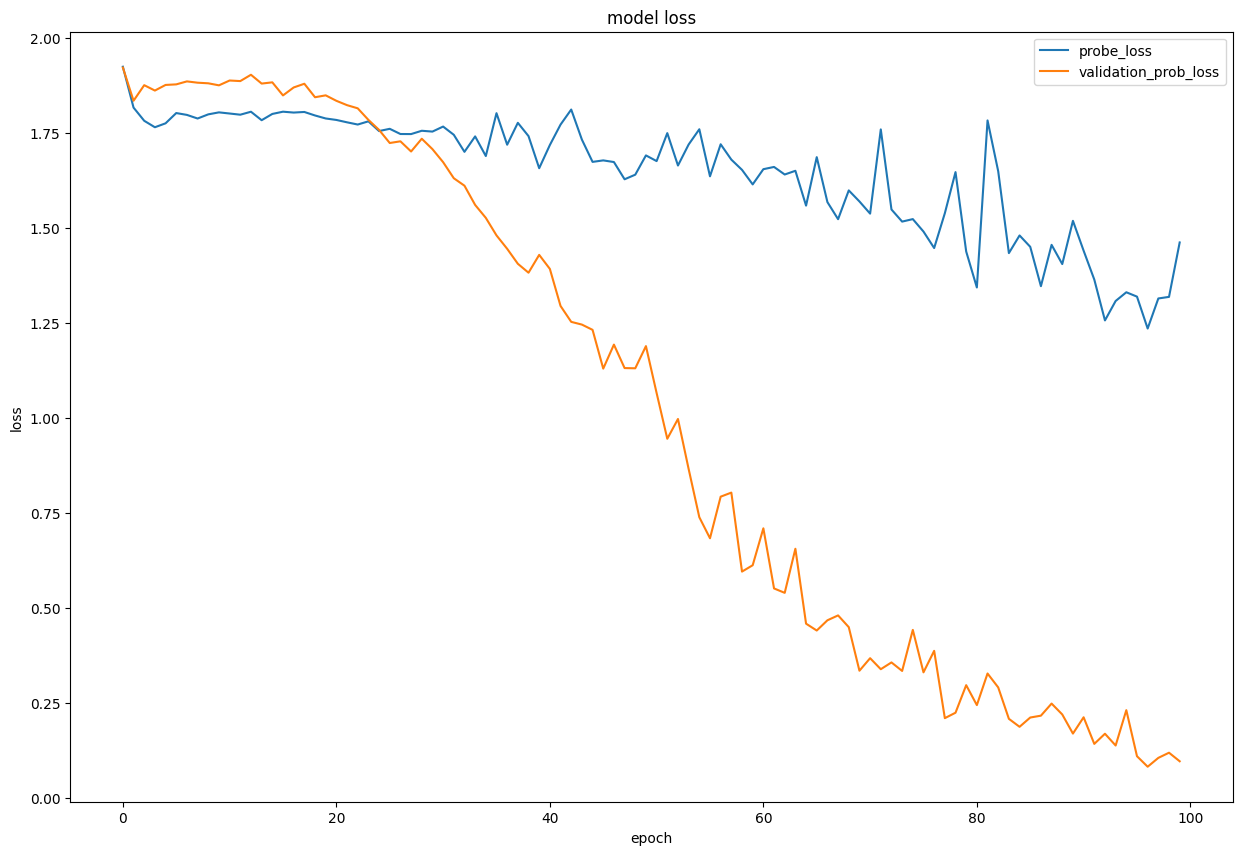

In [10]:
# summarize history for loss
plt.figure(figsize=(15, 10))
# plt.plot(pretrain_history.history['c_loss'])
plt.plot(pretrain_history.history['p_loss'])
plt.plot(pretrain_history.history['val_p_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['probe_loss', 'validation_prob_loss'], loc='upper right')
plt.show()


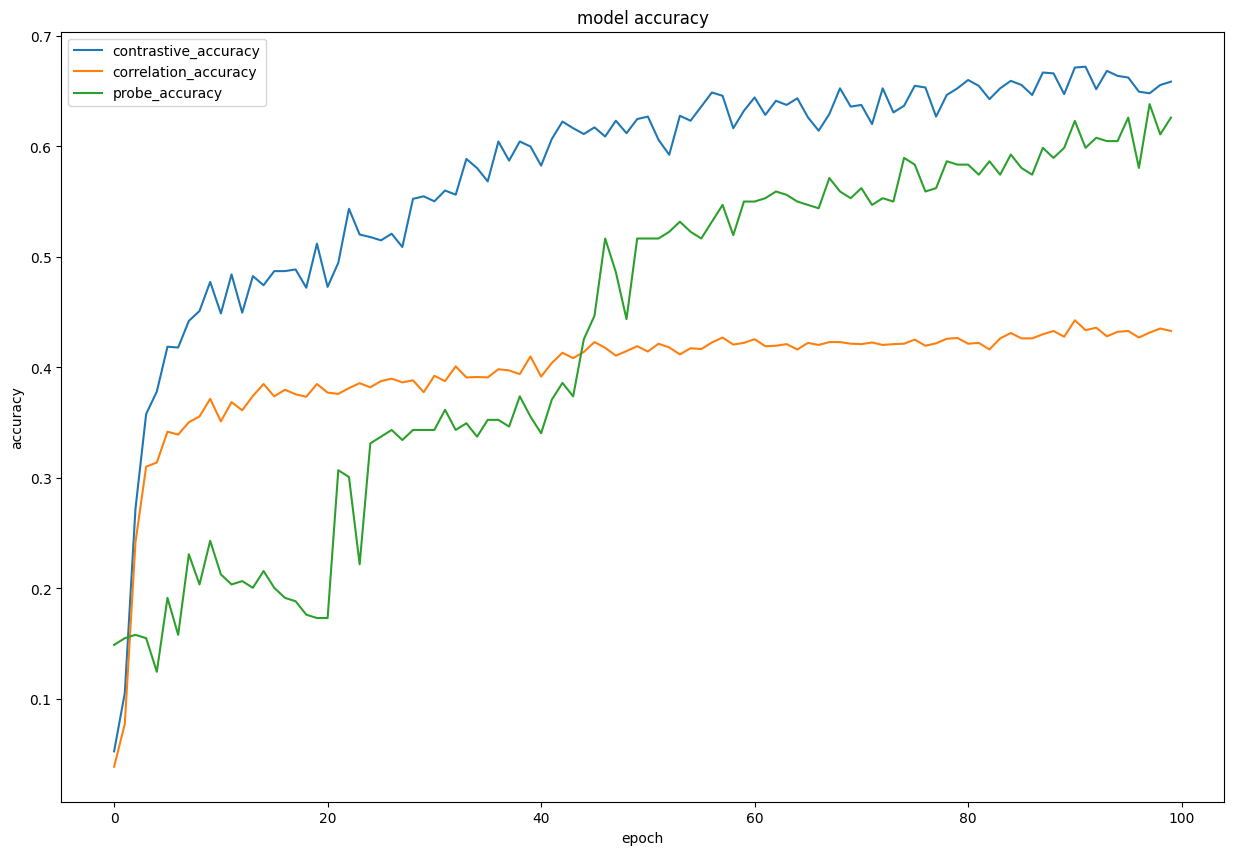

In [11]:

# summarize history for accuracy
plt.figure(figsize=(15, 10))
plt.plot(pretrain_history.history['c_acc'])
plt.plot(pretrain_history.history['r_acc'])
plt.plot(pretrain_history.history['p_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['contrastive_accuracy', 'correlation_accuracy', 'probe_accuracy'], loc='upper left')
plt.show()

## Plot the learned representations using UMAP

Plot the representations of the labeled data in the representation space learned by the NNCLR encoder. Use UMAP to reduce the dimensionality to 2. The color of each point corresponds to its label.

In [12]:
import matplotlib.pyplot as plt
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=16)  # fontsize of the figure title

Text(0.5, 1.0, 'UMAP projection of the representations of the unlabeled data')

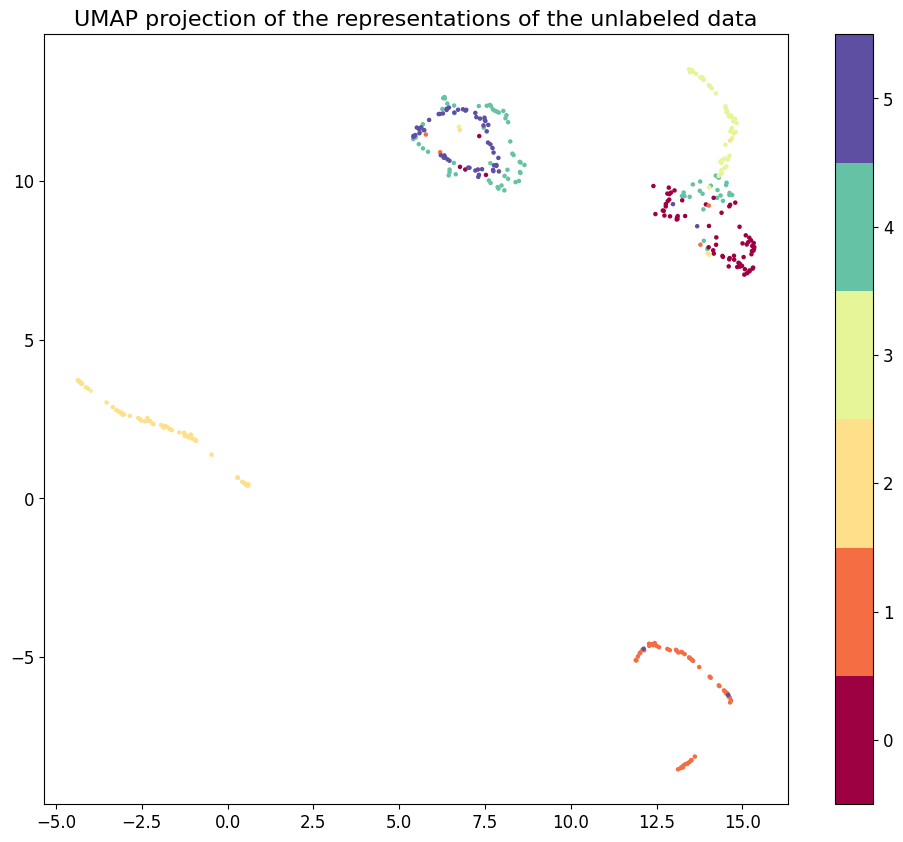

In [13]:
# Plot the representations of the unlabeled data in the representation space learned by the NNCLR encoder. Use UMAP to reduce the dimensionality to 2. The color of each point corresponds to its label.

import umap.umap_ as umap
import numpy as np

# Get the representations of the unlabeled data.
unlabeled_feature_vectors = model.encoder(x_train, training=False)

# Reduce the dimensionality of the representations to 2.
reducer = umap.UMAP()
umap_embeddings = reducer.fit_transform(unlabeled_feature_vectors)

# Plot the representations.
plt.figure(figsize=(12, 10))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=y_train, s=5.0, cmap='Spectral')
# plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(7)-0.5).set_ticks(np.arange(6))
plt.title('UMAP projection of the representations of the unlabeled data')

Text(0.5, 1.0, 'UMAP projection of the representations of the labeled data')

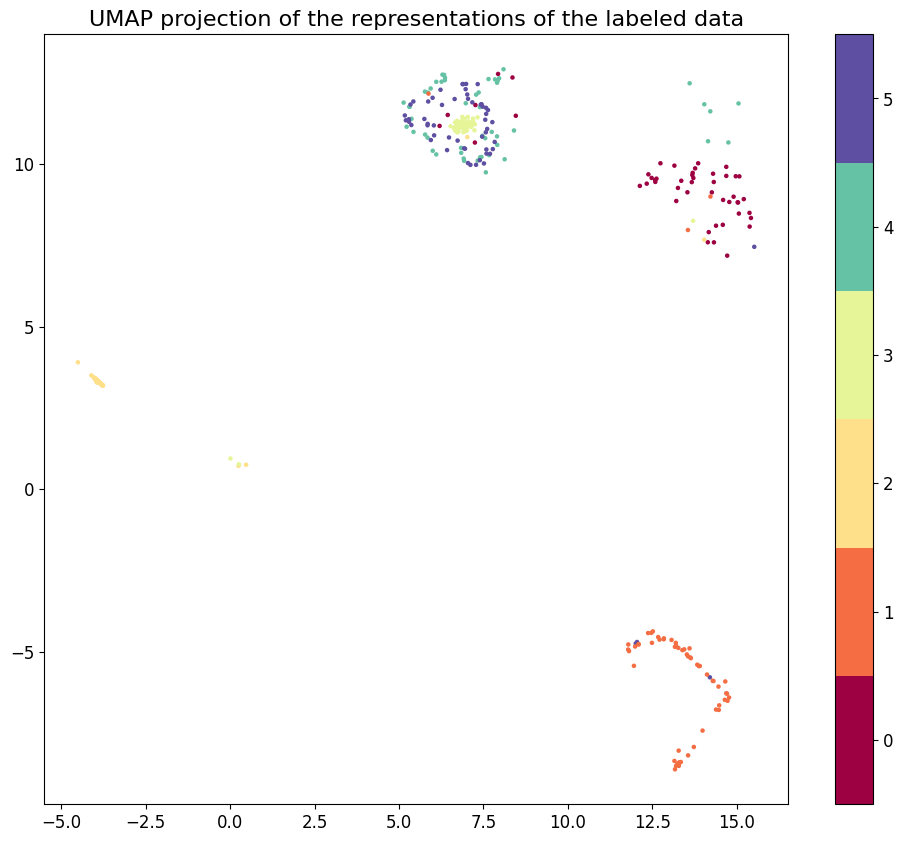

In [14]:
# Plot the representations of the labeled data in the representation space learned by the NNCLR encoder. Use UMAP to reduce the dimensionality to 2.

# Get the representations of the labeled data.
labeled_feature_vectors = model.encoder(x_validate, training=False)

# Reduce the dimensionality of the representations to 2.
# reducer = umap.UMAP()
# umap_embeddings = reducer.fit_transform(labeled_feature_vectors)
umap_embeddings = reducer.transform(labeled_feature_vectors)

# Plot the representations.
plt.figure(figsize=(12, 10))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=y_validate, s=5.0, cmap='Spectral')
# plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(7)-0.5).set_ticks(np.arange(6))
plt.title('UMAP projection of the representations of the labeled data')

Text(0.5, 1.0, 'UMAP projection of the representations of the test data')

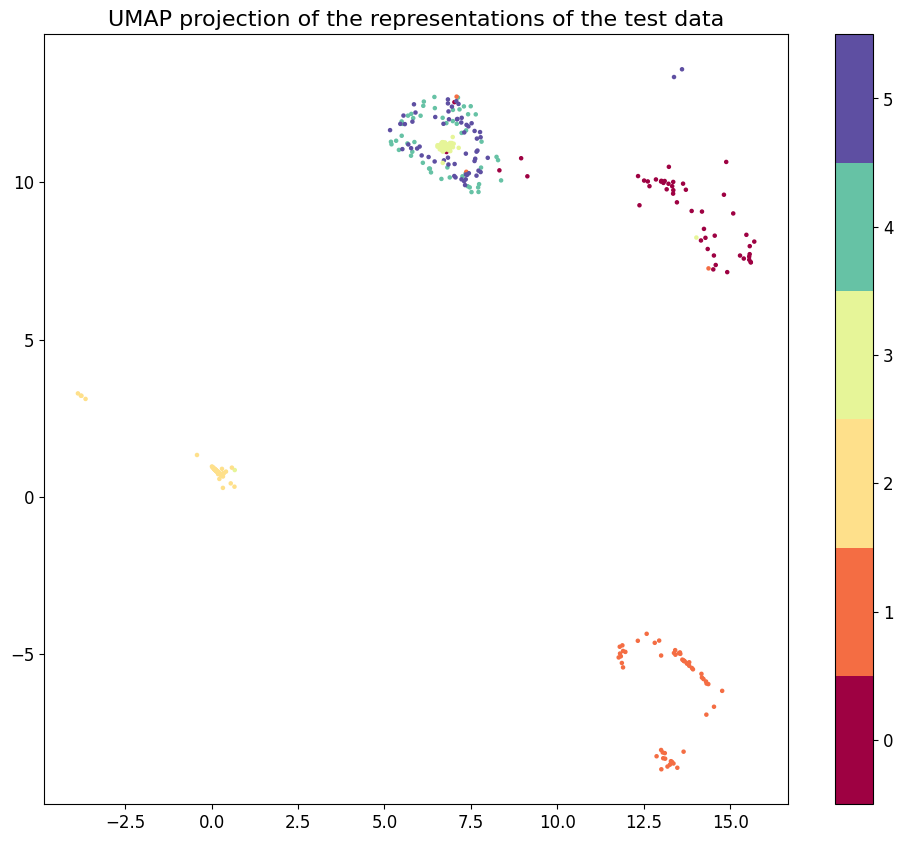

In [15]:
# Plot the representations of the test data in the representation space learned by the NNCLR encoder. Use UMAP to reduce the dimensionality to 2. The color of each point corresponds to its label.

# Get the representations of the test data.
test_feature_vectors = model.encoder(x_test, training=False)

# Reduce the dimensionality of the representations to 2.
# reducer = umap.UMAP()
# umap_embeddings = reducer.fit_transform(test_feature_vectors)
umap_embeddings = reducer.transform(test_feature_vectors)

# Plot the representations.
plt.figure(figsize=(12, 10))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=y_test, s=5.0, cmap='Spectral')
# plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(7)-0.5).set_ticks(np.arange(6))
plt.title('UMAP projection of the representations of the test data')

## Fine tune the model

Fine tune the NNCLR encoder on the labeled data. The classifier is trained on the labeled data.

In [17]:
finetuning_model = keras.Sequential(
    [
        layers.Input(shape=input_shape),
        augmenter("classification_augmenter", input_shape=input_shape),
        model.encoder,
        layers.Dense(n_classes),
    ],
    name="finetuning_model",
)
finetuning_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    run_eagerly=None # True = run eagerly, False = run as graph, None = autodetect
)

finetuning_history = finetuning_model.fit(
    labeled_train_dataset, epochs=finetune_num_epochs, validation_data=test_dataset
)

Epoch 1/100
21/21 [==============================] - 2s 33ms/step - loss: 1.8617 - acc: 0.0578 - val_loss: 1.7722 - val_acc: 0.1272
Epoch 2/100
21/21 [==============================] - 0s 12ms/step - loss: 1.7242 - acc: 0.2553 - val_loss: 1.6862 - val_acc: 0.1923
Epoch 3/100
21/21 [==============================] - 0s 12ms/step - loss: 1.6510 - acc: 0.1884 - val_loss: 1.5664 - val_acc: 0.3846
Epoch 4/100
21/21 [==============================] - 0s 12ms/step - loss: 1.4815 - acc: 0.3708 - val_loss: 1.3535 - val_acc: 0.3491
Epoch 5/100
21/21 [==============================] - 0s 15ms/step - loss: 1.3341 - acc: 0.5076 - val_loss: 1.2160 - val_acc: 0.5118
Epoch 6/100
21/21 [==============================] - 0s 13ms/step - loss: 1.1910 - acc: 0.5076 - val_loss: 1.0759 - val_acc: 0.5237
Epoch 7/100
21/21 [==============================] - 0s 12ms/step - loss: 1.1511 - acc: 0.5319 - val_loss: 1.1894 - val_acc: 0.5089
Epoch 8/100
21/21 [==============================] - 0s 12ms/step - loss: 1.

### Plot the fine-tuning loss and accuracy

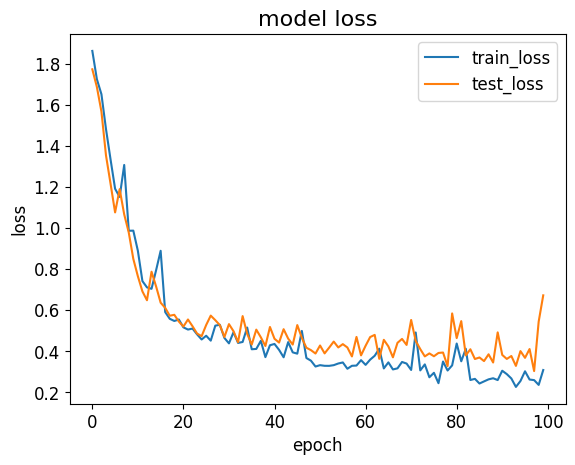

In [18]:
# summarize history for loss

plt.plot(finetuning_history.history['loss'])
plt.plot(finetuning_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'test_loss'], loc='upper right')
plt.show()

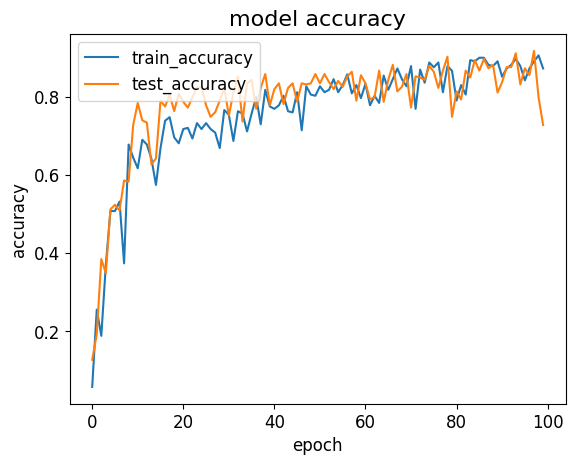

In [19]:
# summarize history for accuracy
plt.plot(finetuning_history.history['acc'])
plt.plot(finetuning_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'test_accuracy'], loc='upper left')
plt.show()


## Evaluate our fine tuned model on the test set

Prediction accuracy: 0.743
              precision    recall  f1-score   support

  Downstairs       0.39      0.92      0.55        49
     Jogging       0.90      0.98      0.94        58
     Sitting       1.00      0.90      0.95        61
    Standing       0.92      1.00      0.96        58
    Upstairs       1.00      0.04      0.07        52
     Walking       0.87      0.57      0.69        60

    accuracy                           0.74       338
   macro avg       0.85      0.73      0.69       338
weighted avg       0.86      0.74      0.71       338

[[45  4  0  0  0  0]
 [ 0 57  0  0  0  1]
 [ 0  1 55  5  0  0]
 [ 0  0  0 58  0  0]
 [46  0  0  0  2  4]
 [25  1  0  0  0 34]]


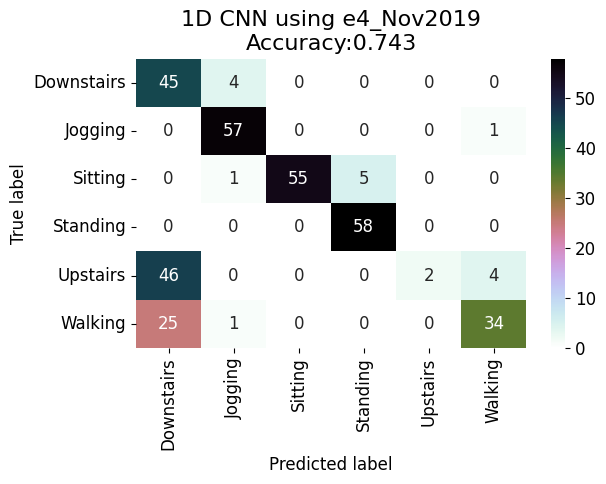

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import pandas as pd
import seaborn as sns
import numpy as np

#### Show results
predictions = finetuning_model.predict(test_dataset, verbose=0, batch_size=32)
#must use values not one-hot encoding, use argmax to convert
y_pred = np.argmax(predictions, axis=-1) # axis=-1 means last axis
y_test = np.concatenate([y for x, y in test_dataset], axis=0)
print('Prediction accuracy: {0:.3f}'.format(accuracy_score(y_test, y_pred)))

print(classification_report(y_test, y_pred, target_names=t_names))
cm = confusion_matrix(y_test, y_pred)
print(cm)
cm_df = pd.DataFrame(cm,
                     index = t_names, 
                     columns = t_names)
fig = plt.figure(figsize=(6.5,5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='cubehelix_r')
plt.title('1D CNN using e4_Nov2019'+'\nAccuracy:{0:.3f}'.format(accuracy_score(y_test, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout() # keeps labels from being cutoff when saving as pdf
plt.show()

## Evaluate the learned representations using a KNN classifier

In [21]:
from sklearn.neighbors import KNeighborsClassifier

# Convert train dataset to feature vectors using the self-supervised encoder
train_feature_vectors = model.encoder(x_train, training=False)

knn = KNeighborsClassifier(n_neighbors=3)
knn_model = knn.fit(train_feature_vectors, y_train)

# Predict test set with the knn model
test_feature_vectors = model.encoder(x_test, training=False)
y_pred = knn_model.predict(test_feature_vectors)

print('Prediction accuracy: {0:.3f}'.format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names=t_names))
cm = confusion_matrix(y_test, y_pred)
print(cm)

Prediction accuracy: 0.932
              precision    recall  f1-score   support

  Downstairs       0.91      0.84      0.87        49
     Jogging       1.00      0.95      0.97        58
     Sitting       0.98      1.00      0.99        61
    Standing       1.00      0.97      0.98        58
    Upstairs       0.81      0.85      0.83        52
     Walking       0.88      0.97      0.92        60

    accuracy                           0.93       338
   macro avg       0.93      0.93      0.93       338
weighted avg       0.93      0.93      0.93       338

[[41  0  0  0  7  1]
 [ 1 55  0  0  1  1]
 [ 0  0 61  0  0  0]
 [ 1  0  1 56  0  0]
 [ 2  0  0  0 44  6]
 [ 0  0  0  0  2 58]]
